# Домашнее задание:
1. Скачать данные соревнования: https://www.kaggle.com/c/bank-issues-1510/data
2. Провести стандартную предобработку: закодировать категориальные признаки, провести стандартизацию числовых. Признак living_region представлен строкой: можно либо удалить его, либо придумать, как преобразовать его в категорию. Заполнить пропуски в данных или удалить строки с пропусками.
3. Отделить целевую переменную - open_account_flag.
4. Построить гистограммы или графики корреляции и исследовать зависимость номера тарифа кредита и суммы кредита от пола/образования/профессии/возраста (можно выбрать любые 2-3 признака) клиента.
5. Попробовать обучить любые два из пройденных на семинаре алгоритма классификации: для каждого из методов подобрать оптимальные гиперпараметры.
6. Зафиксировать лучшую модель и отправить прогноз для тестовых данных на Kaggle. Пример того, как должен выглядеть файл с ответами, можно посмотреть в файле sampleSubmission.csv (также лежит на Kaggle).

In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score as accuracy, precision_score as precision, recall_score as recall, roc_auc_score as roc_auc 
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


In [29]:
train = pd.read_csv("train.csv")
train.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,25,UNM,SPC,26389.0,10,1.32,0.584105,SCH,ОБЛ КУРСКАЯ,35000.0,2.0,0.0,1
1,2,F,37,MAR,SPC,19588.0,12,1.43,0.718935,SCH,РЕСПУБЛИКА ТАТАРСТАН,15000.0,0.0,0.0,1
2,3,F,28,UNM,SPC,53669.0,18,1.10,0.586015,GRD,МОСКВА Г,70000.0,4.0,0.0,1
3,4,M,34,MAR,SPC,26349.0,10,1.43,0.655703,SCH,СВЕРДЛОВСКАЯ ОБЛАСТЬ,42500.0,4.0,0.0,0
4,5,F,43,MAR,UMN,11589.0,10,1.10,0.271893,GRD,РЯЗАНСКАЯ ОБЛАСТЬ,20000.0,3.0,0.0,0


In [30]:
print ("Rows     : " , train.shape[0])
print ("Columns  : " , train.shape[1])
print ("\nFeatures : \n" , train.columns.tolist())
print ("\nMissing values :  ", train.isnull().sum().values.sum())
print ("\nUnique values :  \n", train.nunique())

Rows     :  119518
Columns  :  15

Features : 
 ['client_id', 'gender', 'age', 'marital_status', 'job_position', 'credit_sum', 'credit_month', 'tariff_id', 'score_shk', 'education', 'living_region', 'monthly_income', 'credit_count', 'overdue_credit_count', 'open_account_flg']

Missing values :   13105

Unique values :  
 client_id               119518
gender                       2
age                         54
marital_status               5
job_position                16
credit_sum               35399
credit_month                30
tariff_id                   32
score_shk                15468
education                    5
living_region              285
monthly_income            1330
credit_count                20
overdue_credit_count         4
open_account_flg             2
dtype: int64


In [31]:
train.isna().sum()

client_id                  0
gender                     0
age                        0
marital_status             0
job_position               0
credit_sum                 0
credit_month               0
tariff_id                  0
score_shk                  0
education                  0
living_region            133
monthly_income             0
credit_count            6486
overdue_credit_count    6486
open_account_flg           0
dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020D256ED048>,
      dtype=object)

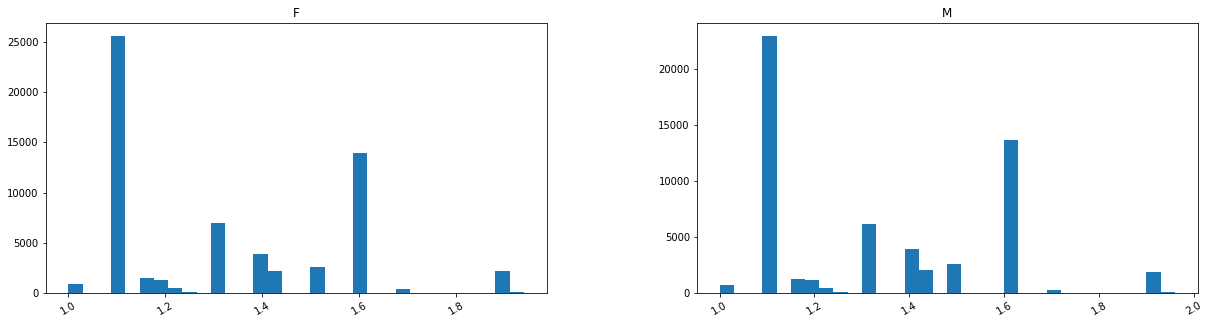

In [32]:
#гистограмма распределения кредитных тарифов в зависимости от пола заемщика
train['tariff_id'].hist(by=train['gender'], bins=32, figsize =(20, 5), xrot=30)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020D2CDC5320>,
      dtype=object)

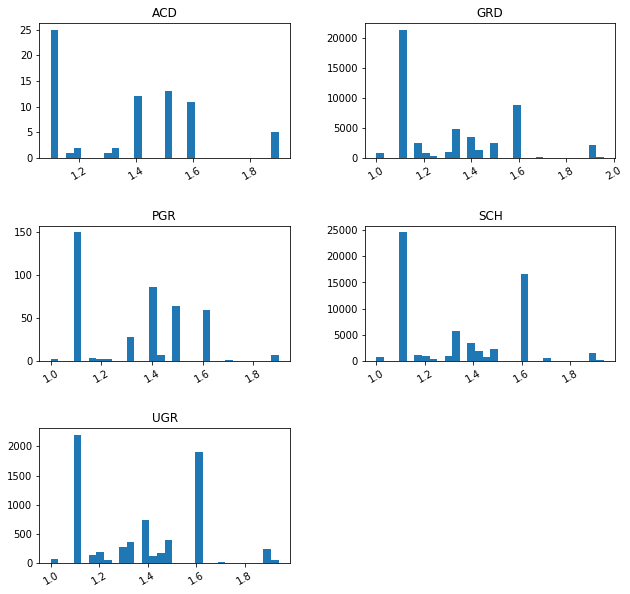

In [33]:
#гистограмма распределения кредитных тарифов в зависимости от уровня образования
train['tariff_id'].hist(by=train['education'], bins=30, figsize =(10, 10), xrot=30)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020D238C0EB8>,
      dtype=object)

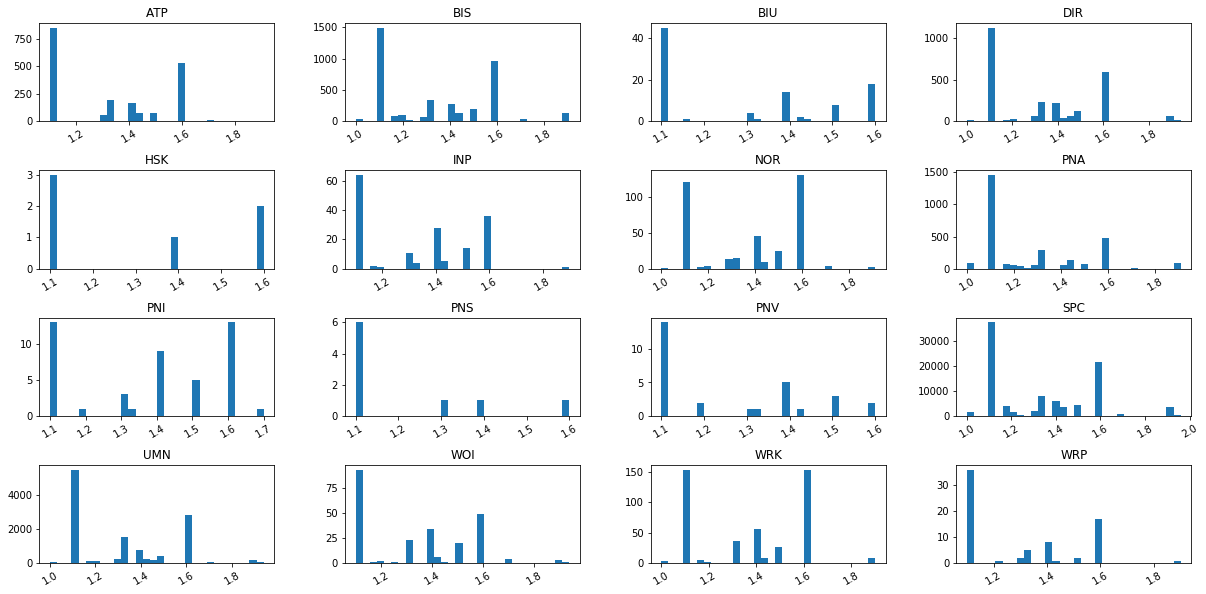

In [34]:
#гистограмма распределения кредитных тарифов в зависимости от профессии
train['tariff_id'].hist(by=train['job_position'], bins=30, figsize =(20, 10), xrot=30)

In [35]:
#корреляция между возрастом заемщика и суммой кредита
train[['age', 'credit_sum']].corr()

,age,credit_sum
age,1.000000,-0.097864
credit_sum,-0.097864,1.000000


In [36]:
#корреляция между величиной месячного дохода заемщика и суммой кредита
train[['monthly_income', 'credit_sum']].corr()

,monthly_income,credit_sum
monthly_income,1.000000,0.351568
credit_sum,0.351568,1.000000


# Проведем стандартную предобработку признаков




In [37]:
#заполняем пропущенные значения

train["living_region"] = train["living_region"].fillna('missing')
train["credit_count"] = train["credit_count"].fillna('missing')
train["overdue_credit_count"] = train["overdue_credit_count"].fillna('missing')

mean_credit_count = np.mean(np.array([float(i) for i in train["credit_count"] if i != 'missing']))
train["credit_count"] = train["credit_count"].replace("missing", mean_credit_count)

mean_overdue_credit_count = np.mean(np.array([float(i) for i in train["overdue_credit_count"] if i != 'missing']))
train["overdue_credit_count"] = train["overdue_credit_count"].replace("missing", mean_overdue_credit_count)

train.isna().sum()

client_id               0
gender                  0
age                     0
marital_status          0
job_position            0
credit_sum              0
credit_month            0
tariff_id               0
score_shk               0
education               0
living_region           0
monthly_income          0
credit_count            0
overdue_credit_count    0
open_account_flg        0
dtype: int64

In [38]:
#рассмотрим категориальные признаки: gender, marital_status, job_position, education, living_region
train[['gender', 'marital_status', 'job_position', 'education', 'living_region']].head()

,gender,marital_status,job_position,education,living_region
0,M,UNM,SPC,SCH,ОБЛ КУРСКАЯ
1,F,MAR,SPC,SCH,РЕСПУБЛИКА ТАТАРСТАН
2,F,UNM,SPC,GRD,МОСКВА Г
3,M,MAR,SPC,SCH,СВЕРДЛОВСКАЯ ОБЛАСТЬ
4,F,MAR,UMN,GRD,РЯЗАНСКАЯ ОБЛАСТЬ


In [39]:
train[['gender', 'marital_status', 'job_position', 'education', 'living_region']].nunique()

gender              2
marital_status      5
job_position       16
education           5
living_region     286
dtype: int64

In [40]:
#кодируем категориальные признаки
train = pd.get_dummies(train, columns = ['marital_status', 'job_position', 'education'], drop_first=True)

encoder = LabelEncoder()
train['gender'] = encoder.fit_transform(train['gender'])

In [41]:
#разбираемся с living_region отдельно
train.drop(['living_region'], axis = 1, inplace=True)

In [42]:
train.head()

,client_id,gender,age,credit_sum,credit_month,tariff_id,score_shk,monthly_income,credit_count,overdue_credit_count,...,job_position_PNV,job_position_SPC,job_position_UMN,job_position_WOI,job_position_WRK,job_position_WRP,education_GRD,education_PGR,education_SCH,education_UGR
0,1,1,25,26389.0,10,1.32,0.584105,35000.0,2.0,0.0,...,0,1,0,0,0,0,0,0,1,0
1,2,0,37,19588.0,12,1.43,0.718935,15000.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0
2,3,0,28,53669.0,18,1.10,0.586015,70000.0,4.0,0.0,...,0,1,0,0,0,0,1,0,0,0
3,4,1,34,26349.0,10,1.43,0.655703,42500.0,4.0,0.0,...,0,1,0,0,0,0,0,0,1,0
4,5,0,43,11589.0,10,1.10,0.271893,20000.0,3.0,0.0,...,0,0,1,0,0,0,1,0,0,0


In [43]:
#числовые признаки: age, credit_sum, credit_month, tariff_id, score_shk, monthly_income, credit_count, overdue_credit_count                           
#стандартизируем числовые признаки 

std = StandardScaler()
scaled = std.fit_transform(train[['age', 'credit_sum', 'credit_month', 'tariff_id', 'score_shk', 'monthly_income', 'credit_count', 'overdue_credit_count']])
scaled = pd.DataFrame(scaled, columns=['age', 'credit_sum', 'credit_month', 'tariff_id', 'score_shk', 'monthly_income', 'credit_count', 'overdue_credit_count'])

scaled.describe()

,age,credit_sum,credit_month,tariff_id,score_shk,monthly_income,credit_count,overdue_credit_count
count,1.195180e+05,1.195180e+05,1.195180e+05,1.195180e+05,1.195180e+05,1.195180e+05,1.195180e+05,1.195180e+05
mean,-6.110230e-17,-2.574438e-16,-1.826460e-15,8.544141e-16,-4.261987e-16,1.348955e-16,-4.959398e-16,2.732867e-15
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-1.754331e+00,-1.436076e+00,-2.255858e+00,-1.374037e+00,-3.785255e+00,-1.374618e+00,-1.216404e+00,-2.251203e-01
25%,-8.064769e-01,-6.883265e-01,-2.769612e-01,-9.506457e-01,-7.223413e-01,-6.016887e-01,-6.377732e-01,-2.251203e-01
50%,-2.377645e-01,-2.982041e-01,-2.769612e-01,-1.918436e-02,-6.485285e-02,-2.032716e-01,-5.914190e-02,-2.251203e-01
75%,6.153041e-01,3.671904e-01,2.884378e-01,1.166312e+00,6.667860e-01,3.943540e-01,5.194894e-01,-2.251203e-01
max,3.269295e+00,1.069128e+01,7.073226e+00,2.690521e+00,5.300667e+00,3.027563e+01,9.777590e+00,1.427666e+01


In [44]:
train[scaled.columns] = scaled[scaled.columns]
train.head()

,client_id,gender,age,credit_sum,credit_month,tariff_id,score_shk,monthly_income,credit_count,overdue_credit_count,...,job_position_PNV,job_position_SPC,job_position_UMN,job_position_WOI,job_position_WRK,job_position_WRP,education_GRD,education_PGR,education_SCH,education_UGR
0,1,1,-1.090833,0.018058,-0.276961,-0.019184,0.918437,-0.203272,-0.059142,-0.22512,...,0,1,0,0,0,0,0,0,1,0
1,2,0,0.046592,-0.400052,0.288438,0.446546,2.004198,-1.000106,-1.216404,-0.22512,...,0,1,0,0,0,0,0,0,1,0
2,3,0,-0.806477,1.695172,1.984635,-0.950646,0.933817,1.191188,1.098121,-0.22512,...,0,1,0,0,0,0,1,0,0,0
3,4,1,-0.237764,0.015599,-0.276961,0.446546,1.495002,0.095541,1.098121,-0.22512,...,0,1,0,0,0,0,0,0,1,0
4,5,0,0.615304,-0.891813,-0.276961,-0.950646,-1.595750,-0.800897,0.519489,-0.22512,...,0,0,1,0,0,0,1,0,0,0


In [45]:
#заметим, что выборка крайне не сбалансирована в пользу отказа в выдаче кредита
# 0 ~ 80%
# 1 ~ 20%
train.open_account_flg.groupby(train['open_account_flg']).size()

open_account_flg
0    98448
1    21070
Name: open_account_flg, dtype: int64

In [46]:
count_class_0, count_class_1 = train.open_account_flg.value_counts()

#divide by class
train_class_0 = train[train['open_account_flg'] == 0]
train_class_1 = train[train['open_account_flg'] == 1]

Random under-sampling:
1    21070
0    21070
Name: open_account_flg, dtype: int64


(42140, 34)

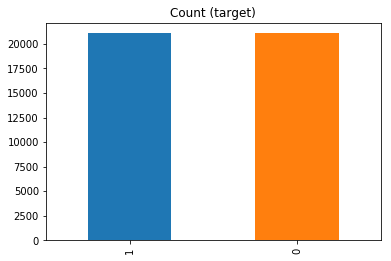

In [47]:
train_class_0_under = train_class_0.sample(count_class_1)
train_under = pd.concat([train_class_0_under, train_class_1], axis=0)

print('Random under-sampling:')
print(train_under.open_account_flg.value_counts())

train_under.open_account_flg.value_counts().plot(kind='bar', title='Count (target)')
train = train_under
train.shape

Random over-sampling:
1    98448
0    98448
Name: open_account_flg, dtype: int64


(196896, 34)

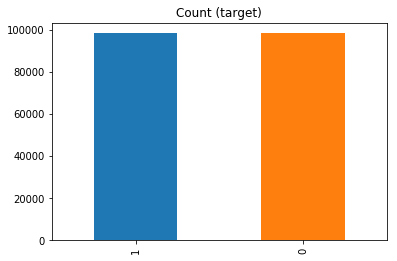

In [48]:
train_class_1_over = train_class_1.sample(count_class_0, replace=True)
train_over = pd.concat([train_class_0, train_class_1_over], axis=0)

print('Random over-sampling:')
print(train_over.open_account_flg.value_counts())

train_over.open_account_flg.value_counts().plot(kind='bar', title='Count (target)')
train = train_over
train.shape

# Logistic Regression

In [49]:
target = train.open_account_flg
train.drop(columns=['open_account_flg', 'client_id'], inplace=True)

In [50]:
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
LR = LogisticRegression()

#Create hyperparameter options
hyperparameters = dict(penalty=penalty)

clf = GridSearchCV(LR, hyperparameters, cv=10, verbose=0)
best_model = clf.fit(train, target)

print('Best penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

predictions = best_model.predict(train)
probas = [i[1] for i in best_model.predict_proba(train)]
print('accuracy:', accuracy(target, predictions))
print('precision:', precision(target, predictions))
print('recall:', recall(target, predictions))
print('ROC AUC:', roc_auc(target, probas))

Best penalty: l2
Best C: 1.0
accuracy: 0.6027953843653502
precision: 0.6030948839673194
recall: 0.6013428408906225
ROC AUC: 0.6452436573255476


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.33, random_state=42)
LR = LogisticRegression()
LR.fit(X_train, y_train)

pd.DataFrame({"feature": train.columns, "importance": LR.coef_[0]})

,feature,importance
0,gender,0.195457
1,age,-0.165403
2,credit_sum,-0.221373
3,credit_month,0.056296
4,tariff_id,-0.282199
5,score_shk,0.168342
6,monthly_income,0.064584
7,credit_count,0.122274
8,overdue_credit_count,0.030359
9,marital_status_DIV,-0.127004


# kNN

In [ ]:
n_neighbors = list(range(3, 4))
algorithm = ['auto', 'ball_tree'] 
knn = KNeighborsClassifier()

#train = train[['job_position_PNS', 'job_position_PNA']]

#Create hyperparameter options
hyperparameters = dict(n_neighbors=n_neighbors, algorithm=algorithm)

clf = GridSearchCV(knn, hyperparameters, cv=2, verbose=0)
best_model = clf.fit(train, target)

print('Best K:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best algorithm:', best_model.best_estimator_.get_params()['algorithm'])

predictions = best_model.predict(train)
probas = [i[1] for i in best_model.predict_proba(train)]
print('accuracy:', accuracy(target, predictions))
print('precision:', precision(target, predictions))
print('recall:', recall(target, predictions))
print('ROC AUC:', roc_auc(target, probas))

# SVM

In [ ]:
C = np.logspace(0, 4, 10)
kernel = ['linear', 'poly', 'rbf']
svm = SVC()
          
#Create hyperparameter options
hyperparameters = dict(C=C, kernel=kernel)

#train = train[['job_position_PNS', 'job_position_PNA']]
          
clf = GridSearchCV(svm, hyperparameters, cv=10, verbose=0)
best_model = clf.fit(train, target)
          
print('Best C', best_model.best_estimator_.get_params()['C'])
print('Best kernel:', best_model.best_estimator_.get_params()['kernel'])

predictions = best_model.predict(train)
probas = [i[1] for i in best_model.predict_proba(train)]
print('accuracy:', accuracy(target, predictions))
print('precision:', precision(target, predictions))
print('recall:', recall(target, predictions))
print('ROC AUC:', roc_auc(target, probas))

# Строим предсказание на лучшей модели

In [ ]:
test = pd.read_csv('test.csv')

print ("Rows     : " , test.shape[0])
print ("Columns  : " , test.shape[1])
print ("\nFeatures : \n" , test.columns.tolist())
print ("\nMissing values :  ", test.isnull().sum().values.sum())
print ("\nUnique values :  \n", test.nunique())

In [ ]:
test.isna().sum()

In [ ]:
#применим к данным тестовой выборки те же изменения, что и к тренировочным данным

#заполняем пропущенные значения
test["living_region"] = test["living_region"].fillna('missing')
test["credit_count"] = test["credit_count"].fillna('missing')
test["overdue_credit_count"] = test["overdue_credit_count"].fillna('missing')
test["monthly_income"] = test["monthly_income"].fillna('missing')

mean_credit_count = np.mean(np.array([float(i) for i in test["credit_count"] if i != 'missing']))
test["credit_count"] = test["credit_count"].replace("missing", mean_credit_count)

mean_overdue_credit_count = np.mean(np.array([float(i) for i in test["overdue_credit_count"] if i != 'missing']))
test["overdue_credit_count"] = test["overdue_credit_count"].replace("missing", mean_overdue_credit_count)

mean_monthly_income = np.mean(np.array([float(i) for i in test["monthly_income"] if i != 'missing']))
test["monthly_income"] = test["monthly_income"].replace("missing", mean_monthly_income)

#кодируем категориальные признаки
test = pd.get_dummies(test, columns = ['marital_status', 'job_position', 'education'], drop_first=True)

encoder = LabelEncoder()
test['gender'] = encoder.fit_transform(test['gender'])

#разбираемся с living_region отдельно
test.drop(['living_region'], axis = 1, inplace=True)

#стандартизируем числовые признаки 
std = StandardScaler()
scaled = std.fit_transform(test[['age', 'credit_sum', 'credit_month', 'tariff_id', 'score_shk', 'monthly_income', 'credit_count', 'overdue_credit_count']])
scaled = pd.DataFrame(scaled, columns=['age', 'credit_sum', 'credit_month', 'tariff_id', 'score_shk', 'monthly_income', 'credit_count', 'overdue_credit_count'])
test[scaled.columns] = scaled[scaled.columns]

#удаляем лишний столбец client_id
ids = test['client_id']
test.drop(columns=['client_id'], inplace=True)

predictions = best_model.predict(test)

s = pd.DataFrame({'client_id': ids, 'open_account_flg': predictions})
s.to_csv('submission.csv', index=False)